# Homework 1: Numpy, Scipy, Pandas

### Due Monday Feb 5, 2018 @ 2pm


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="data/screenshot_1.png">

Name your repo something sensible (e.g., python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="data/screenshot_2.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
cd /class/directories ## this will be different on your machine...whereever you want to keep your work.

# change <username> to your github username:
git clone https://github.com/<username>/python-ay250-homework.git
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp -r Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
```

e. To submit your work, go to this form to register your homework Repo URL (https://goo.gl/forms/4DTPxonYBAxmfxJG2). If you've made your repo private, you'll need to add us as collaborators to the repo.  Our Github handles are `@profjsb` and `@chelseaharris`.

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="Data/im2-1.png">

A tarball of the data is at: https://drive.google.com/open?id=0B4vIeCR-xYNnbXFJTTVlVnpUZkk

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint1: you'll need to figure out how to resize a numpy array
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [322]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt

#Files not included in github! To run, place original image files in a folder "data_1" in working directory

#Find where black boundaries are, so we can get rid of them (makes the image rectangular instead of square)
im0 = plt.imread("data_1/im2-0.png")[:,:,0] #all RGB (or other color scheme?) values are same, might as well just use first
sm = np.sum(im0,axis=1)
firstQ = False
for i in range(im0.shape[0]):
    if sm[i]!=im0.shape[0] and not firstQ:
        idx_f = i
        firstQ = True
    if firstQ and sm[i]==im0.shape[0]:
        idx_l = i-1
        break

def readAndResize(filename):
    """
    Given filename string, reads file into numpy array, subtracts mean, and buffers with zeros so that the final image is 3 times the size
    Deletes blackspace for better results
    """
    im0 = plt.imread(filename)[:,:,0][idx_f:idx_l,:] #all RGB (or other color scheme?) values are same, might as well just use first
    im0 -= np.mean(im0)
    zr = np.zeros(im0.shape)
    zrs = np.concatenate((zr,zr,zr))
    im0 = np.concatenate((zrs,np.concatenate((zr,im0,zr)),zrs),axis=1) #not the most elegant, but had problems with np.resize
    #im0s = np.concatenate((im0,im0,im0))
    #im0 = np.concatenate((im0s,im0s,im0s),axis=1)
    return im0

def findOffset(im0,im1,window=10):
    """
    Given two resized images, returns a tuple of the (x,y) offset, calculated by finding the COM in a grid of size window x window about the peak of the convolution of the images
    """
    conv = ss.fftconvolve(im0, im1[::-1, ::-1]) #convolve using FFT
    #conv *= weight
    peakx,peaky = np.unravel_index(np.argmax(conv), conv.shape) #find indices of convolution maximum
    
    #For decimal precision, now find "Center of Mass" (COM) in window x window region about maximum
    small_conv = conv[(peakx-window):(peakx+window+1),(peaky-window):(peaky+window+1)]
    Xs = np.asarray([[x for x in range(2*window+1)] for y in range(2*window+1)]) - window
    Ys = np.asarray([[y for x in range(2*window+1)] for y in range(2*window+1)]) - window
    COMx = np.sum(Xs*small_conv)/np.sum(small_conv) + peakx
    COMy = np.sum(Ys*small_conv)/np.sum(small_conv) + peaky
    
    #Translate index to shift
    COMx -= (im0.shape[0]-1)
    COMy -= (im0.shape[1]-1)
    
    return (COMx,COMy)

num_images = 100
images = [readAndResize("data_1/im2-" + str(i) + ".png") for i in range(num_images)] #load all images
offs = [findOffset(images[0],image,window=40) for image in images] #find all offsets (offset of i^th image is (i+1)^th element)

#Print results:
for i,off in enumerate(offs):
    print("Offset of image " + str(i) + " is " + "(" + str(round(off[0],2)) + ", " + str(round(off[1],2)) + ")\n")


Offset of image 0 is (0.0, 0.0)

Offset of image 1 is (3.03, -13.08)

Offset of image 2 is (41.0, -2.02)

Offset of image 3 is (58.99, 11.05)

Offset of image 4 is (0.04, 0.04)

Offset of image 5 is (1.99, 11.01)

Offset of image 6 is (44.98, 23.92)

Offset of image 7 is (0.01, -40.03)

Offset of image 8 is (22.02, -12.06)

Offset of image 9 is (0.04, -27.05)

Offset of image 10 is (35.05, -3.1)

Offset of image 11 is (19.01, -55.01)

Offset of image 12 is (21.05, -8.09)

Offset of image 13 is (8.01, -34.9)

Offset of image 14 is (19.05, -3.09)

Offset of image 15 is (59.0, -6.03)

Offset of image 16 is (37.98, 11.06)

Offset of image 17 is (19.02, -24.11)

Offset of image 18 is (36.0, -31.99)

Offset of image 19 is (14.01, -8.01)

Offset of image 20 is (-15.98, -26.92)

Offset of image 21 is (26.02, -36.02)

Offset of image 22 is (16.02, -32.11)

Offset of image 23 is (5.04, -36.02)

Offset of image 24 is (38.03, -21.03)

Offset of image 25 is (40.06, -20.91)

Offset of image 26 is (0

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

In [323]:
import scipy
#List of images shifted using spline interpolation
images_shifted = [scipy.ndimage.interpolation.shift(image,off) for image,off in zip(images,offs)]

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

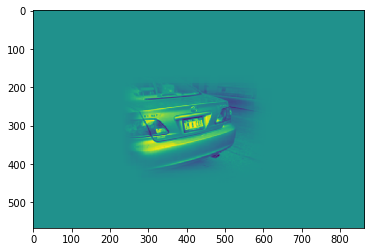

In [325]:
image_sum = sum(images_shifted)/len(images_shifted)
plt.imshow(image_sum)
plt.show()
#IM A CAR (!)

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [326]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

Populating the interactive namespace from numpy and matplotlib


We define a simple utility function to listen to audio files right in the browser:

In [327]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [592]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x,Fs=2) #Had to alter instructor's code to set keyword arg Fs = 2 to get specgram to work
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `Homeworks/hw1/data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [513]:
# your code here
Audio("data/voice.wav")

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [422]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    xft = np.fft.rfft(x) #fourier transform
    upper_idx = round(len(xft)*(1-fraction))
    bad_idxs = np.argsort(abs(xft))[:upper_idx] #find least prevalent frequencies
    xft[bad_idxs] = 0 #set least prevalent frequencies to have amplitude 0
    x_c = np.fft.irfft(xft,len(x))
    
    return x_c


As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

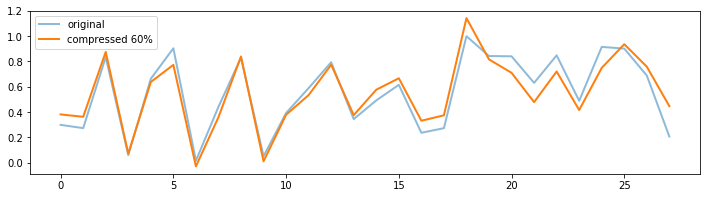

In [427]:
fraction = .6  # play changing this in the 0-1 range #0 is max filtered (no signal), 1 is no filter

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [604]:
import scipy.io.wavfile

def rescaleArray(array,minval,maxval):
    """
    Rescales array such that its values lie in the interval [minval,maxval] & rounds elements to nearest integer
    """
    mn,mx = min(array),max(array)
    array_new =  array*(maxval-minval)/(mx-mn) + (mx - maxval*(maxval-minval)/(mx-mn)) #rescale
    return array_new

def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    rate, x = scipy.io.wavfile.read(fname) #read from file
    x_approx = compress_signal(x,fraction) #compress
    
    #Convert x_approx back to x's type
    if x.dtype == 'float32':
        x_approx = rescaleArray(x_approx,-1.,1.)
        x_approx = x_approx.astype(dtype('float32'))
    elif x.dtype == 'int32':
        x_approx = rescaleArray(x_approx,-2147483648,2147483647)
        x_approx = x_approx.astype(dtype('int32'))
    elif x.dtype == 'int16':
        x_approx = rescaleArray(x_approx,-32768,32767)
        x_approx = x_approx.astype(dtype('int16'))
    elif x.dtype == 'uint8':
        x_approx = rescaleArray(x_approx,0,255)
        x_approx = x_approx.astype(dtype('uint8'))
    else:
        raise ValueError("File was not in recognized data type.")
    
    new_fname = fname[:(len(fname)-4)] + "_comp_" + str(1.*fraction) + ".wav" #new file name
    scipy.io.wavfile.write(new_fname,rate,x_approx) #write
    
    return rate, x, x_approx, new_fname
    

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](http://docs.python.org/2/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [609]:
from collections import OrderedDict

ratios = [.1,.5,.75,.9,.95,.99]
voices = OrderedDict() #keys are ratios, values are tuple (compress_audio numpy array, filename)
for r in ratios:
    rate,x,x_approx,filename = compress_wav("data/voice.wav",r)
    voices.update({r: (x_approx,filename)})


**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

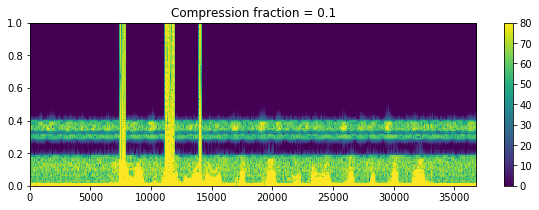

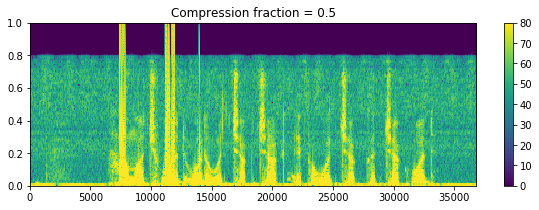

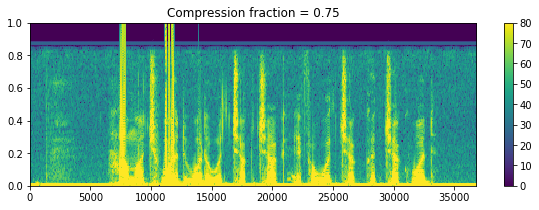

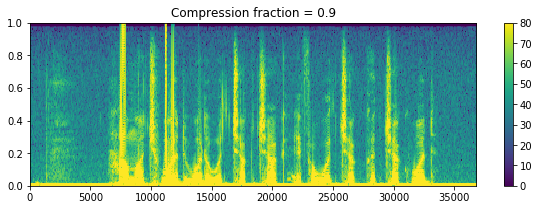

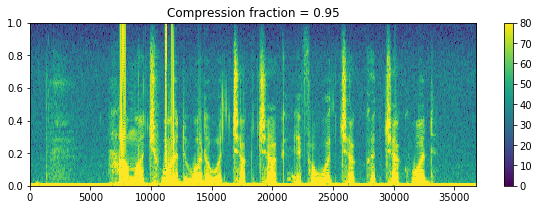

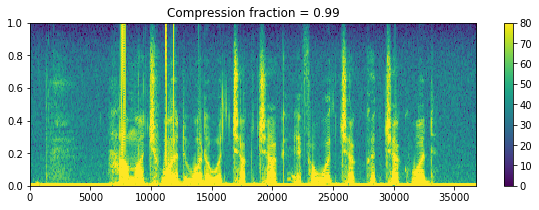

In [610]:
#Understandable even down to compression ratio .1 (sidenote: I also tested .01 and it was not understandable)
#Lots of background fuzz at higher compressions though
for r,v in voices.items():
    Audio("data/voice" + "_comp_" + str(1.*r) + ".wav")
    specgram_cbar(v[0],title="Compression fraction = " + str(r))


# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle` (you'll want to normalize your signal so it has a mean of zero.)

In [713]:
from scipy.signal.spectral import lombscargle
import datetime
import matplotlib.pylab as plt

data = pd.read_csv('merged_data.csv')
x = data['Week']
y = data['full moon']

data['Week'] = pd.to_datetime(data['Week']) #Convert string to datetime
data.set_index('Week', inplace=True) #set index to datetimes

timedeltas = data.index - data.index[0] #get timedelta since first day
timedeltas = timedeltas.days.values #convert to array of number of days since first day

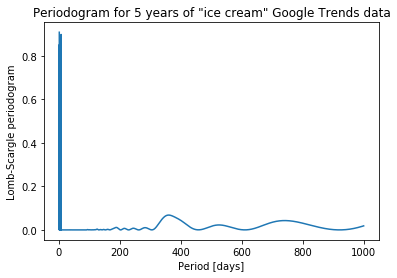

Estimate of length of year from "ice cream" Google Trends data: 359.98


In [723]:
#Number of days in a year:
#Used ice cream data; tennis or volleyball may also provide some estimate but may be off due to scheduling differences of major events
#Still some discrepancy (estimate is ~5 days off) in using ice cream data: only 5 year sample size + variation due to year-to-year weather, ice cream buying trends, etc.
#This uncertainty can be seen in the large width of the yearly peak

#Prep for lombscargle
x = timedeltas
y = data["ice cream"].values
nout = 10000
per = np.linspace(1,1000, nout)
f = 2*np.pi/per #periods to test

pgram = lombscargle(x, y, f, normalize=True) #get periodogram from x,y data

#Plot periodogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Periodogram for 5 years of \"ice cream\" Google Trends data")
ax.set_xlabel("Period [days]")
ax.set_ylabel("Lomb-Scargle periodogram")
    
ax.plot(per,pgram)
plt.show()

#Calculate maximum of periodogram (outside of very low frequencies) to estimate length of year
pgram_nolow = pgram[per > 50] #eliminate weekly and monthly freqs (per 7, 30 < 50)
numlost = len(pgram) - len(pgram_nolow) #how many datapoints just eliminated
yr_length = per[np.argmax(pgram_nolow) + numlost] #what period does the maximum of pgram correspond to

print("Estimate of length of year from \"ice cream\" Google Trends data: " + str(round(yr_length,2)))

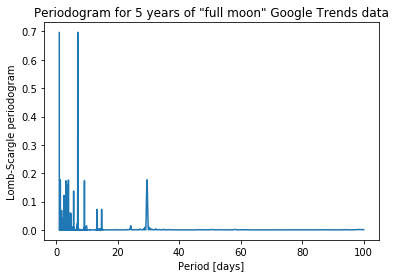

Estimate of length of moon cycle from "full moon" Google Trends data: 29.53


In [720]:
#Number of days in a month: use full moon data

#Prep for lombscargle
x = timedeltas
y = data["full moon"].values
nout = 10000
per = np.linspace(1,100, nout)
f = 2*np.pi/per #periods to test

pgram = lombscargle(x, y, f, normalize=True) #get periodogram from x,y data

#Plot periodogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Periodogram for 5 years of \"full moon\" Google Trends data")
ax.set_xlabel("Period [days]")
ax.set_ylabel("Lomb-Scargle periodogram")
    
ax.plot(per,pgram)
plt.show()

#Calculate maximum of periodogram (outside of very low frequencies) to estimate length of year
pgram_nolow = pgram[per > 10] #eliminate low (< 10)) freqs
numlost = len(pgram) - len(pgram_nolow) #how many datapoints just eliminated
m_length = per[np.argmax(pgram_nolow) + numlost] #what period does the maximum of pgram correspond to

print("Estimate of length of moon cycle from \"full moon\" Google Trends data: " + str(round(m_length,2)))


# #4: Reproducing some insights about the Election

Nate ("not a genius, just a Bayesian") Silver writes often about polls and their utility of predicting elections. One of the things he emphasized during the 2016 campaign is that even "large" polls of people with a consistent lead for one candidate will show wild swings in any given window in time.

**Problem 1**: Using Pandas and `numpy`, try to reproduce this plot from a Nate Silver Tweet qualitatively using the same assumptions.

<img src="https://www.evernote.com/l/AUU-KkH3Z-lBdKokzCzVIUe53YZLQ9e_AuMB/image.png">

https://twitter.com/NateSilver538/status/769565612955824128

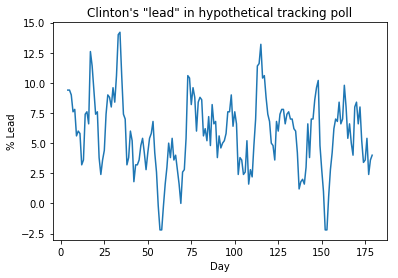

In [730]:
import pandas as pd
import matplotlib.pylab as plt

def getPollingAvg(pt_lead,daily_int,days_kept,total_days):
    p_c = (50 + pt_lead/2.)/100.
    s_1day = pd.Series(200*(np.random.binomial(daily_int, p_c,total_days)/daily_int - .5),
              index=range(total_days)) #results of each day's interviews, drawn from binomial distr
    s_Nday = pd.Series([np.mean(s_1day[(i-days_kept+1):(i+1)]) for i in range(total_days)],index=range(total_days)) #avg of previous days_kept days interviews
    df = pd.DataFrame({'1Day': s_1day, 'NDay': s_Nday}).dropna() #dataframe combining the two, drop NaN for first days_kept days
    return df

#Specific parameters to use
pt_lead = 6
daily_int = 200
days_kept = 5
total_days = 180

#Get results and plot
polavg = getPollingAvg(pt_lead,daily_int,days_kept,total_days)

#Plot lead
fig = plt.figure()
ax = polavg["NDay"].plot()
ax.set_title("Clinton's \"lead\" in hypothetical tracking poll")
ax.set_xlabel("Day")
ax.set_ylabel("% Lead")
    
plt.show()


**Problem 2**: Clearly, even with a 6% point lead, there's a chance that this sort of poll would show the other person in the lead. How much would ahead (in percent) would a candidate need to be to have a tracking poll never show the other candidate to be ahead over the course of a year (in your simulation)?

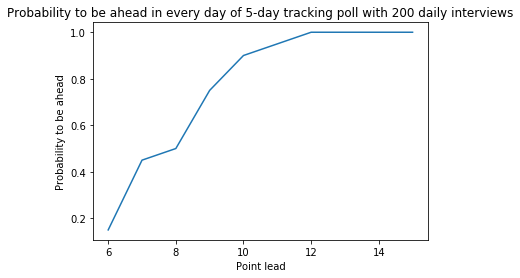

In [729]:
#No discrete cutoff, so I'll estimate the probability to be ahead as a function of the point lead
#Estimate probability by running 20 trials (each it's own year-long tracking poll) and taking estimated probablity as the empirical probablity
#Result: Somewhere between a 7 and 9 point lead is where probability gets close to 1
num_trials = 20

pt_leads = np.asarray([pt_lead for pt_lead in np.linspace(6,15,10)])
p_est = 0*pt_leads

for i in range(num_trials):
    poll_avgs = [getPollingAvg(pt_lead,200,5,round(364/2))['NDay'] for pt_lead in pt_leads]
    always_ahead = [all(poll_avg>0) for poll_avg in poll_avgs]
    p_est += always_ahead
    
p_est /= num_trials

#Plot results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Probability to be ahead in every day of 5-day tracking poll with 200 daily interviews")
ax.set_xlabel("Point lead")   
ax.set_ylabel("Probability to be ahead")    

ax.plot(pt_leads,p_est)

plt.show()


**Problem 3**: With a 3 and 6% lead, how many people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead (over a year)?

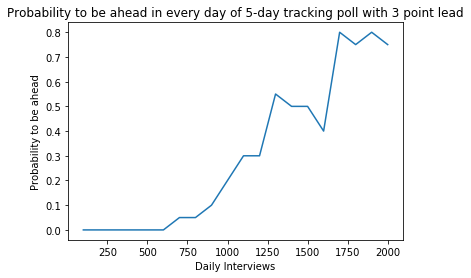

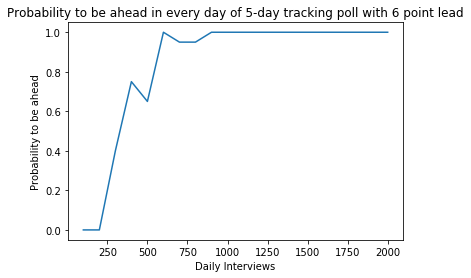

In [731]:
#No discrete cutoff, so I'll estimate the probability to be ahead as a function of the point lead
#Estimate probability by running 20 trials (each it's own year-long tracking poll) and taking estimated probablity as the empirical probablity
#Result: 3 pt lead: Somewhere around 2000 daily interviews
#Result: 6 pt lead: Somewhere around 500 daily interviews

num_trials = 20

daily_ints = np.asarray([daily_int for daily_int in np.linspace(100,2000,20)])
p_est = 0*daily_ints
#For 3 pt lead
pt_lead = 3
for i in range(num_trials):
    poll_avgs = [getPollingAvg(pt_lead,daily_int,5,round(364/2))['NDay'] for daily_int in daily_ints]
    always_ahead = [all(poll_avg>0) for poll_avg in poll_avgs]
    p_est += always_ahead
    
p_est /= num_trials

#Plot results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Probability to be ahead in every day of 5-day tracking poll with " + str(pt_lead) + " point lead")
ax.set_xlabel("Daily Interviews")   
ax.set_ylabel("Probability to be ahead")    

ax.plot(daily_ints,p_est)

#For 6 pt lead
p_est = 0*daily_ints
pt_lead = 6
for i in range(num_trials):
    poll_avgs = [getPollingAvg(pt_lead,daily_int,5,round(364/2))['NDay'] for daily_int in daily_ints]
    always_ahead = [all(poll_avg>0) for poll_avg in poll_avgs]
    p_est += always_ahead
    
p_est /= num_trials

#Plot results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Probability to be ahead in every day of 5-day tracking poll with " + str(pt_lead) + " point lead")
ax.set_xlabel("Daily Interviews")   
ax.set_ylabel("Probability to be ahead")    

ax.plot(daily_ints,p_est)

plt.show()